In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importo la base

In [ ]:
file_path = 'https://drive.google.com/file/d/1LJLaiIPyKUhRYrcSToXx-vmogZgD5dmR/view?usp=drive_link'
file_id = file_path.split('/')[-2]
download_url = f'https://drive.google.com/uc?id={file_id}'

data_transactional_table = pd.read_csv(download_url, delimiter=',', index_col=0, encoding='latin1')
display(data_transactional_table)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2020-12-01 01:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2020-12-01 01:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2020-12-01 01:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2020-12-01 01:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2020-12-01 01:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2022-12-09 06:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2022-12-09 06:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2022-12-09 06:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2022-12-09 06:50:00,4.95,12680.0,France


Limpio la base

In [ ]:
#Elimino las filas con valores negativos de la columna Quantity
data_transactional_table = data_transactional_table[data_transactional_table['Quantity'] >= 0]

#Excluyo las filas que representan cancelaciones de la columna Invoice
data = data_transactional_table[~data_transactional_table['Invoice'].str.contains('C')]

In [ ]:
#Cuantifico los valores faltantes y los reemplazo por NaN
columns_to_replace_nan = ['StockCode', 'Description', 'InvoiceDate', 'Customer ID', 'Country','Quantity', 'Price']
data[columns_to_replace_nan] = data[columns_to_replace_nan].fillna(np.nan)
nan_counts = data[['StockCode', 'Description', 'InvoiceDate', 'Customer ID', 'Country','Quantity', 'Price']].isna().sum()

print("Valores NaN por columna:")
print(nan_counts)

<ipython-input-131-5f3d6a2957db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_replace_nan] = data[columns_to_replace_nan].fillna(np.nan)


Valores NaN por columna:
StockCode           0
Description      1693
InvoiceDate         0
Customer ID    238800
Country             0
Quantity            0
Price               0
dtype: int64


In [ ]:
#Transformo la columna InoviceDate a un formato de fecha y hora
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

#Filtro los datos del año 2022
data_2022 = data[data['InvoiceDate'].dt.year == 2022]

#Almaceno en una nueva columna el numero de semana correspondiente a cada venta
data_2022['Week2022'] = data_2022['InvoiceDate'].dt.isocalendar().week

<ipython-input-132-fba9a220fe03>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
<ipython-input-132-fba9a220fe03>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2022['Week2022'] = data_2022['InvoiceDate'].dt.isocalendar().week


In [ ]:
#Identifico el total de productos que se vendieron durante el 2022
merged_data = data_2022.groupby('StockCode', as_index=False)['Quantity'].sum()
display(merged_data)

,StockCode,Quantity
0,10002,789
1,10080,495
2,10120,177
3,10123C,4
4,10124A,12
...,...,...
3830,gift_0001_10,39
3831,gift_0001_20,20
3832,gift_0001_30,37
3833,gift_0001_40,2


In [ ]:
#Identifico los productos con demanda mas alta en funcion de las cantidades vendidas
merged_data_sorted = merged_data.sort_values(by='Quantity', ascending=False)
display(merged_data_sorted)


,StockCode,Quantity
2433,23843,80995
1987,23166,78033
1079,22197,54183
2859,84077,49852
3318,85099B,46326
...,...,...
2629,47570b,1
2853,84031b,1
2852,84031a,1
3570,90068,1


In [ ]:
#Extraigo los StockCode que pertenecen al quintil superior en terminos de ventas
quintile_value = merged_data_sorted['Quantity'].quantile(0.8)
quintile_data = merged_data_sorted[merged_data_sorted['Quantity'] >= quintile_value]
display(quintile_data)



,StockCode,Quantity
2433,23843,80995
1987,23166,78033
1079,22197,54183
2859,84077,49852
3318,85099B,46326
...,...,...
2444,35471D,1823
2297,23501,1823
8,10135,1820
1493,22651,1819


In [ ]:
data_2022['Week'] = data_2022['InvoiceDate'].dt.week

#Creo una tabla dinámica
pivot_table = data_2022[data_2022['StockCode'].isin(quintile_data['StockCode'])].pivot_table(
    index='StockCode',
    columns='Week',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

display(pivot_table)


<ipython-input-136-b4b30f2977f7>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data_2022['Week'] = data_2022['InvoiceDate'].dt.week
<ipython-input-136-b4b30f2977f7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2022['Week'] = data_2022['InvoiceDate'].dt.week


Week,1,2,3,4,5,6,7,8,9,10,...,40,41,42,43,44,45,46,47,48,49
StockCode,,,,,,,,,,,,,,,,,,,,,
10133,11,67,92,10,0,10,10,14,56,2,...,0,0,0,0,0,0,0,0,0,0
10135,225,116,260,12,1,1,51,216,24,2,...,5,6,21,33,47,36,35,37,61,39
15034,169,5,3,0,24,8,0,48,39,12,...,49,397,0,145,397,28,20,112,16,2
15036,18,159,39,112,1913,68,762,128,91,369,...,721,224,194,101,83,107,104,237,143,14
15039,5,30,4,0,17,4,4,1,0,2,...,3,13,52,51,15,100,13,95,2,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85199S,34,11,6,35,5,5,28,55,16,56,...,79,58,86,143,299,246,113,152,181,202
85204,2,13,26,47,0,2,15,12,11,6,...,195,1,288,1,0,13,122,112,7,8
85212,72,72,96,0,0,0,84,24,12,0,...,0,14,48,0,12,12,12,12,24,24


Realizo las predicciones con un XGBoost

In [ ]:
#Importo la biblioteca de XGBoost
import xgboost as xgb

predictions = {}

#Numero de semanas a predecir
n_weeks_to_predict = 8

#Hiperparámetros
learning_rate = 0.01
n_estimators = 300
max_depth = 3
reg_lambda = 0
reg_alpha = 0

#La iteración del bucle se centra en un producto en particular y utiliza datos históricos para hacer predicciones sobre las cantidades futuras de ese producto
for stock_code in pivot_table.index:
    data_for_stock = pivot_table.loc[stock_code]
    y = data_for_stock.iloc[-n_weeks_to_predict:].values

    X = data_for_stock.iloc[:-n_weeks_to_predict].values.reshape(1, -1)

#Instancio el modelo con los hiperparámetros especificados
    model = xgb.XGBRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha
    )

#Entreno el modelo
    model.fit(X, y)

    predictions[stock_code] = np.round(model.predict(X)).astype(int).tolist()

print(predictions)


{'10133': [[0, 0, 0, 0, 0, 0, 0, 0]], '10135': [[20, 31, 45, 34, 33, 35, 58, 37]], '15034': [[0, 138, 378, 27, 19, 107, 15, 2]], '15036': [[185, 96, 79, 102, 99, 225, 136, 13]], '15039': [[49, 49, 14, 95, 12, 90, 2, 44]], '15056BL': [[41, 160, 87, 43, 69, 19, 10, 67]], '15056N': [[56, 100, 6, 34, 93, 8, 31, 63]], '16008': [[74, 160, 377, 142, 80, 23, 297, 297]], '16014': [[19, 0, 2873, 10, 0, 489, 68, 57]], '16045': [[571, 190, 190, 285, 285, 95, 285, 95]], '16156S': [[48, 48, 119, 119, 48, 95, 119, 48]], '16161P': [[119, 285, 285, 24, 71, 95, 24, 143]], '16161U': [[95, 24, 71, 24, 48, 119, 71, 0]], '16169E': [[344, 190, 499, 547, 143, 309, 239, 238]], '16216': [[0, 0, 48, 0, 238, 13, 81, 100]], '16218': [[228, 6, 385, 19, 0, 48, 90, 95]], '16219': [[95, 47, 3, 52, 68, 83, 64, 6]], '16235': [[116, 16, 14, 37, 30, 104, 39, 49]], '16237': [[10, 31, 301, 105, 153, 128, 257, 161]], '16259': [[0, 4, 0, 19, 0, 0, 0, 0]], '17003': [[194, 1601, 95, 104, 300, 451, 124, 263]], '17084R': [[137, 6

Predicciones

In [ ]:
#Ordeno las predicciones en un data frame nuevo
data = [{'StockCode': stock_code, **{f'Week_{i+1}': pred[0][i] for i in range(len(pred[0]))}} for stock_code, pred in predictions.items()]

predictions_stockcode = pd.DataFrame(data)
predictions_stockcode.to_excel('predicciones.xlsx', index=False)

display(predictions_stockcode)

,StockCode,Week_1,Week_2,Week_3,Week_4,Week_5,Week_6,Week_7,Week_8
0,10133,0,0,0,0,0,0,0,0
1,10135,20,31,45,34,33,35,58,37
2,15034,0,138,378,27,19,107,15,2
3,15036,185,96,79,102,99,225,136,13
4,15039,49,49,14,95,12,90,2,44
...,...,...,...,...,...,...,...,...,...
762,85199S,82,136,284,234,107,145,172,192
763,85204,274,1,0,12,116,107,7,8
764,85212,46,0,11,11,11,11,23,23
765,M,14,1092,824,1179,69,1630,10,770


Analisis gráfico

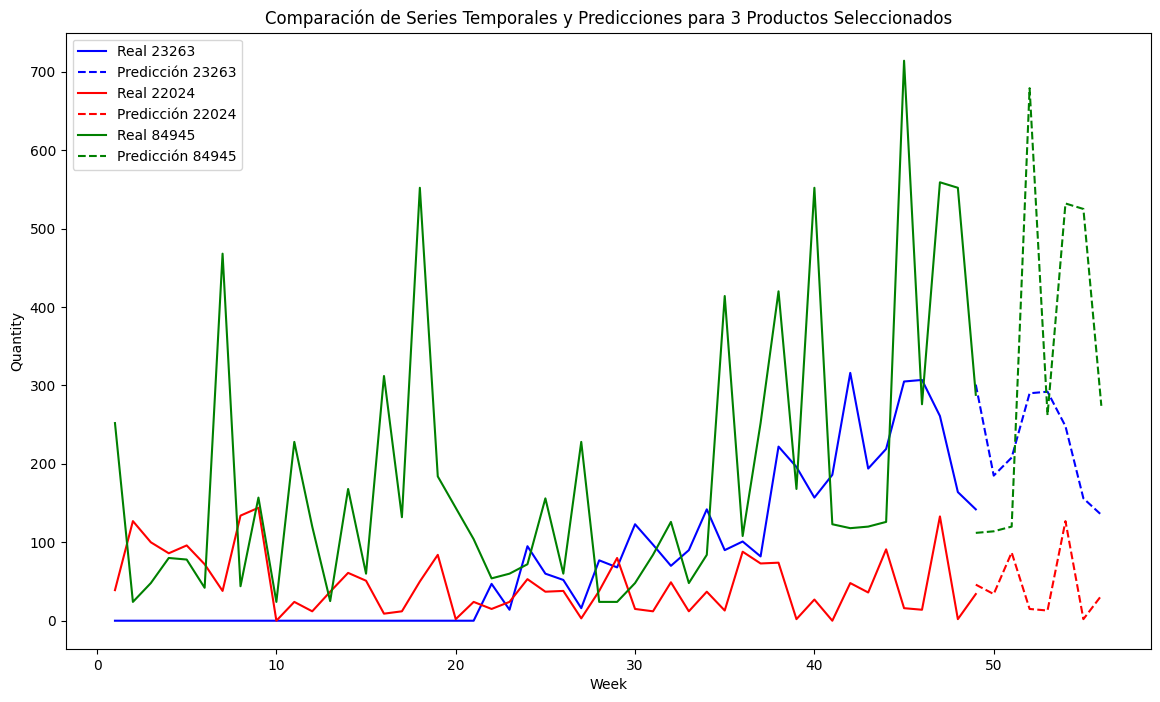

In [ ]:
import matplotlib.pyplot as plt
import random

selected_products = random.sample(predictions_stockcode['StockCode'].tolist(), 3)

plt.figure(figsize=(14, 8))
plt.xlabel('Week')
plt.ylabel('Quantity')
plt.title('Comparación de Series Temporales y Predicciones para 3 Productos Seleccionados')
colors = ['blue', 'red', 'green']

for i, stock_code in enumerate(selected_products):
    real_series = pivot_table.loc[stock_code].values
    prediction_series = predictions_stockcode[predictions_stockcode['StockCode'] == stock_code].values[0][1:]

    plt.plot(range(1, len(real_series) + 1), real_series, label=f'Real {stock_code}', color=colors[i])
    plt.plot(range(len(real_series), len(real_series) + len(prediction_series)), prediction_series, label=f'Predicción {stock_code}', color=colors[i], linestyle='--')

plt.legend(loc='upper left')
plt.show()



Métricas

In [ ]:
stock_codes = []
mae_scores = []
mape_scores = []
rmse_scores = []
rmspe_scores = []

for stock_code in pivot_table.index:
    true_values = pivot_table.loc[stock_code].values[-n_weeks_to_predict:]
    predicted_values = predictions_stockcode[predictions_stockcode['StockCode'] == stock_code].values[0][1:]

    stock_codes.append(stock_code)

    mae = mean_absolute_error(true_values, predicted_values)
    mape = np.mean(np.abs((true_values - predicted_values) / (true_values + 1e-6))) * 100
    rmse = sqrt(mean_squared_error(true_values, predicted_values))
    rmspe = (np.sqrt(np.mean(np.square((true_values - predicted_values) / (true_values + 1e-6))))) * 100

    mae_scores.append(mae)
    mape_scores.append(mape)
    rmse_scores.append(rmse)
    rmspe_scores.append(rmspe)

metricas = pd.DataFrame({
    'StockCode': stock_codes,
    'MAE': mae_scores,
    'MAPE': mape_scores,
    'RMSE': rmse_scores,
    'RMSPE': rmspe_scores
})

display(metricas)


,StockCode,MAE,MAPE,RMSE,RMSPE
0,10133,0.000,0.000000,0.000000,0.000000
1,10135,2.000,5.224914,2.061553,5.252804
2,15034,4.250,3.612399,7.399324,4.227260
3,15036,6.000,5.123849,6.763875,5.181988
4,15039,2.375,4.832595,2.936835,5.290123
...,...,...,...,...,...
762,85199S,8.750,4.909863,9.354143,4.914162
763,85204,3.250,2.741967,5.678908,3.983072
764,85212,1.000,5.729166,1.118034,6.421264
765,M,36.000,4.579062,46.494623,4.929378
